In [138]:
import pandas as pd
import numpy as np
import random
import transformers
import torch
import dotenv
import os
import matplotlib.pyplot as plt

dotenv.load_dotenv()

True

In [139]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto",
    token=os.getenv('HF_TOKEN')
)

terminators = [
    pipeline.tokenizer.eos_token_id,
    pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [140]:
def make_problem(digits, format=None):
    if format is None:
        n = random.randint(10**(digits-1), 10**digits-1)
        return str(n), n
    elif format[0] == '+':
        p1 = make_problem(digits, format[1][0])
        p2 = make_problem(digits, format[1][1])
        return f"({p1[0]}+{p2[0]})", p1[1] + p2[1]
    elif format[0] == '-':
        p1 = make_problem(digits, format[1][0])
        p2 = make_problem(digits, format[1][1])
        return f"({p1[0]}-{p2[0]})", p1[1] - p2[1]
    elif format[0] == '*':
        p1 = make_problem(digits, format[1][0])
        p2 = make_problem(digits, format[1][1])
        return f"({p1[0]}*{p2[0]})", p1[1] * p2[1]
    
def make_problem_set(digits, format, num_problems):
    return pd.DataFrame([make_problem(digits, format) for _ in range(num_problems)], columns=['problem', 'correct_solution'])

In [141]:
def solve_problem_cot(problem, sys_prompt, cot_prompt):
    messages = [
    {"role": "system", "content": sys_prompt + ' ' + cot_prompt},
    {"role": "user", "content": problem},
    ]

    outputs = pipeline(
    messages,
    max_new_tokens=256,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
    pad_token_id=pipeline.tokenizer.eos_token_id
    )

    return outputs[0]['generated_text'][-1]['content']

def solve_problem_set_cot(problem_set, sys_prompt, cot_prompt):
    solved = problem_set.copy()
    solved['solution'] = [solve_problem_cot(row['problem'], sys_prompt, cot_prompt) for _, row in problem_set.iterrows()]
    return solved

def solve_problem_fp(problem, sys_prompt, fp_prompt, max_toks=10):
    messages = [
    {"role": "system", "content": sys_prompt + ' ' + fp_prompt},
    {"role": "user", "content": problem},
    ]

    outputs = pipeline(
    messages,
    max_new_tokens=max_toks,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
    pad_token_id=pipeline.tokenizer.eos_token_id
    )

    return outputs[0]['generated_text'][-1]['content']

def solve_problem_set_fp(problem_set, sys_prompt, fp_prompt):
    solved = problem_set.copy()
    solved['solution'] = [solve_problem_fp(row['problem'], sys_prompt=sys_prompt, fp_prompt=fp_prompt) for _, row in problem_set.iterrows()]
    return solved

In [142]:
def correct_rate(solution_set):
    df_with_correct = solution_set.copy()
    df_with_correct['correct'] = df_with_correct.apply(lambda x: str(x['correct_solution']) in x['solution'], axis=1)
    return df_with_correct

In [143]:
def bernoulli_std(mean, samples):
    return np.sqrt((mean*(1-mean))/samples)

def do_full_test(digits, format, sys_prompt, cot_prompt, fp_prompt, n):
    df = make_problem_set(digits, format, n)
    df_cot = solve_problem_set_cot(df, sys_prompt, cot_prompt)
    df_cot = correct_rate(df_cot)
    df_fp = solve_problem_set_fp(df, sys_prompt, fp_prompt)
    df_fp = correct_rate(df_fp)
    cot_mean = sum(df_cot['correct'])/n
    fp_mean = sum(df_fp['correct'])/n
    print(f"COT accuracy: {cot_mean} +- {2*bernoulli_std(cot_mean, n):.3f}\nFP accuracy: {fp_mean} +- {2*bernoulli_std(fp_mean, n):.3f}")
    return df_cot, df_fp

In [144]:
task_p = 'What is the value of this expression?'
cot_p_add = 'Think through your answer carefully, and show all your work.'
cot_p_mul = 'Think through your answer carefully, and show all your work.'
fp_p = 'Answer with only a number.'

n_samples = 100

In [145]:
results_add = []

for n in range(1, 13):
    results_add.append(do_full_test(n,
             ('+', (None, None)),
             task_p,
             cot_p_add,
             fp_p,
             n_samples))

In [ ]:
results_mul = []

for n in range(1, 5):
    results_mul.append(do_full_test(n,
             ('*', (None, None)),
             task_p,
             cot_p_add,
             fp_p,
             n_samples))

COT accuracy: 1.0 +- 0.000
FP accuracy: 1.0 +- 0.000
COT accuracy: 0.8 +- 0.253
FP accuracy: 0.7 +- 0.290
COT accuracy: 0.1 +- 0.190
FP accuracy: 0.1 +- 0.190
COT accuracy: 0.0 +- 0.000
FP accuracy: 0.0 +- 0.000


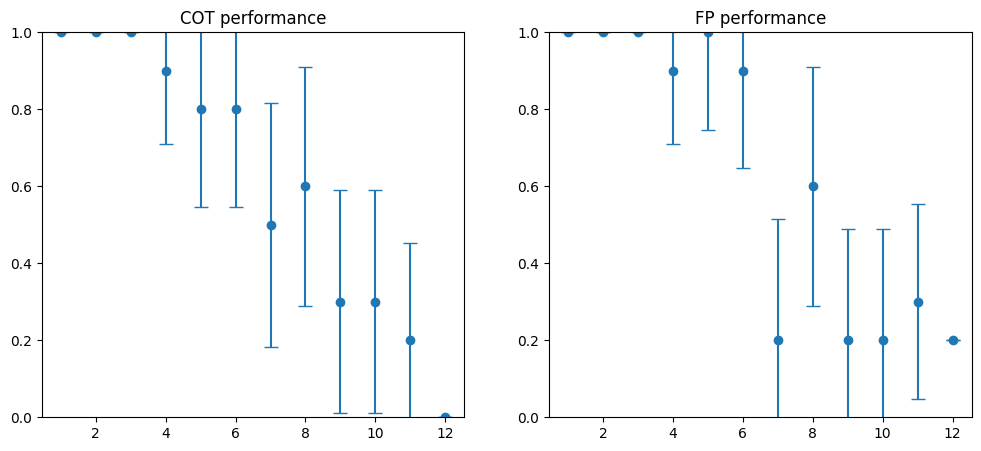

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.errorbar(
    x = range(1, len(results_add)+1),
    y = [sum(df_cot['correct'])/n_samples for df_cot, _ in results_add],
    yerr = [2*bernoulli_std(sum(df_cot['correct'])/n_samples, n_samples) for df_cot, _ in results_add],
    linestyle='',
    fmt='o',
    capsize=5
)
ax1.set_title('COT performance')
ax1.set_ylim(0, 1)
ax2.errorbar(
    x = range(1, len(results_add)+1),
    y = [sum(df_fp['correct'])/n_samples for _, df_fp in results_add],
    yerr = [2*bernoulli_std(sum(df_fp['correct'])/n_samples, n_samples) for df_fp, _ in results_add],
    linestyle='',
    fmt='o',
    capsize=5
)
ax2.set_title('FP performance')
ax2.set_ylim(0, 1)
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.errorbar(
    x = range(1, len(results_mul)+1),
    y = [sum(df_cot['correct'])/n_samples for df_cot, _ in results_mul],
    yerr = [2*bernoulli_std(sum(df_cot['correct'])/n_samples, n_samples) for df_cot, _ in results_mul],
    linestyle='',
    fmt='o',
    capsize=5
)
ax1.set_title('COT performance')
ax1.set_ylim(0, 1)
ax2.errorbar(
    x = range(1, len(results_mul)+1),
    y = [sum(df_fp['correct'])/n_samples for _, df_fp in results_mul],
    yerr = [2*bernoulli_std(sum(df_fp['correct'])/n_samples, n_samples) for df_fp, _ in results_mul],
    linestyle='',
    fmt='o',
    capsize=5
)
ax2.set_title('FP performance')
ax2.set_ylim(0, 1)
plt.show()